In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


**Фиксируем рандомный сид**


In [16]:
np.random.seed(52)
torch.manual_seed(52)

**функция создания датасета**

In [17]:
def data_gen(func, n_samples=2000):
    X = np.random.uniform(-10, 10, (n_samples, 1))
    y = func(X) + np.random.normal(0, 0.1, X.shape)
    return X, y

**функции для создания датасета**

In [18]:
functions = [
    lambda x: np.sin(x) + 0.52 * x,
    lambda x: np.tanh(x) + 0.228 * x**2,
    lambda x: np.cos(x) + 0.1337 * x**3
]

In [19]:
datasets = [data_gen(f) for f in functions]

**размер датасета**

In [20]:
for tensor in datasets[0]:
    print(tensor.shape)

(2000, 1)
(2000, 1)


**распределение датасетов**

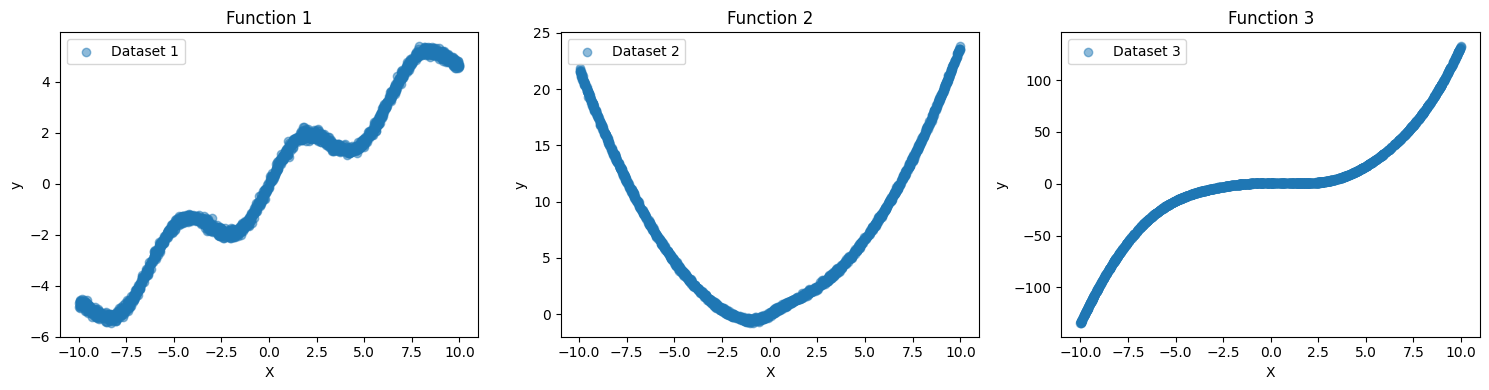

In [21]:
plt.figure(figsize=(15, 4))

for i, (X, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X, y, alpha=0.5, label=f"Dataset {i+1}")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"Function {i+1}")
    plt.legend()

plt.tight_layout()
plt.show()

**Функция разделения датасета**

In [22]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
    return map(torch.tensor, (X_train, X_test, y_train, y_test))

In [23]:
datasets = [list(split_data(X, y)) for X, y in datasets]

In [24]:
for tensor in datasets[0]:
    print(tensor.shape)

torch.Size([1600, 1])
torch.Size([400, 1])
torch.Size([1600, 1])
torch.Size([400, 1])


**Модель с 3 линейными слоями**

In [25]:
class RegressionModel(nn.Module):
    def __init__(self, batch_norm=False, dropout=0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10) if batch_norm else nn.Identity(),
            nn.Dropout(dropout),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10) if batch_norm else nn.Identity(),
            nn.Dropout(dropout),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.model(x)

**функция обучения модели**

In [26]:
def train_model(model, X_train, y_train, X_test, y_test, batch_size, lr=0.01, epochs=100):
    train_loader = torch.utils.data.DataLoader(
        list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True
    )
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch.float()).squeeze(-1) 
            loss = criterion(y_pred, y_batch.float().squeeze(-1))
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
    
    return losses

In [27]:
batch_sizes = [16, 32, 64]
results = {}

for batch_size in batch_sizes:
    losses_per_func = []
    for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
        model = RegressionModel(batch_norm=True)
        losses = train_model(model, X_train, y_train, X_test, y_test, batch_size)
        losses_per_func.append(losses)
    results[f'batch_size_{batch_size}'] = losses_per_func

**График зависимости размера банча и СКО для каждого датасета**

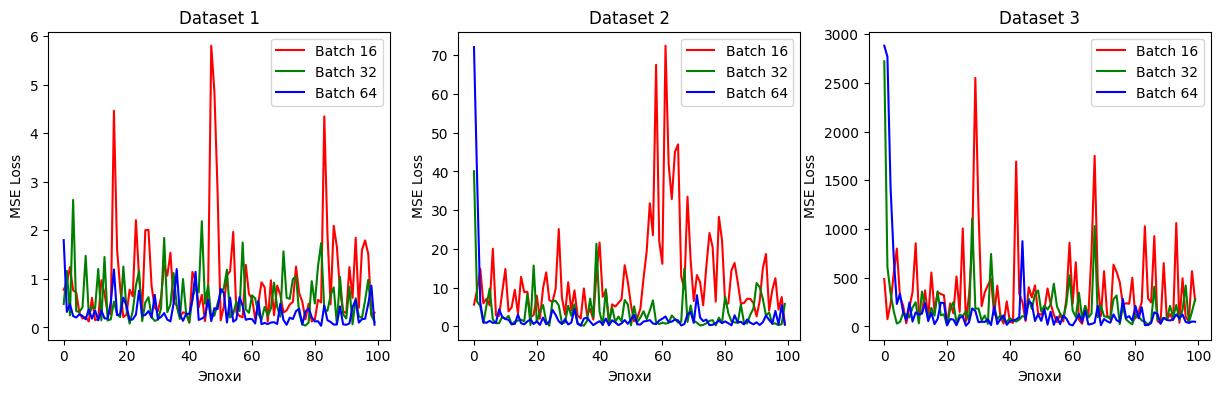

In [34]:
plt.figure(figsize=(15, 4))

colors = ['r', 'g', 'b']
for i in range(len(datasets)):
    plt.subplot(1, len(datasets), i + 1)
    for j, batch_size in enumerate(batch_sizes):
        losses = results[f'batch_size_{batch_size}'][i]
        plt.plot(losses, label=f'Batch {batch_size}', color=colors[j])

    plt.xlabel("Эпохи")
    plt.ylabel("MSE Loss")
    plt.title(f"Dataset {i+1}")
    plt.legend()

**График зависимости размера банча от СКО в среднем по датасетам**

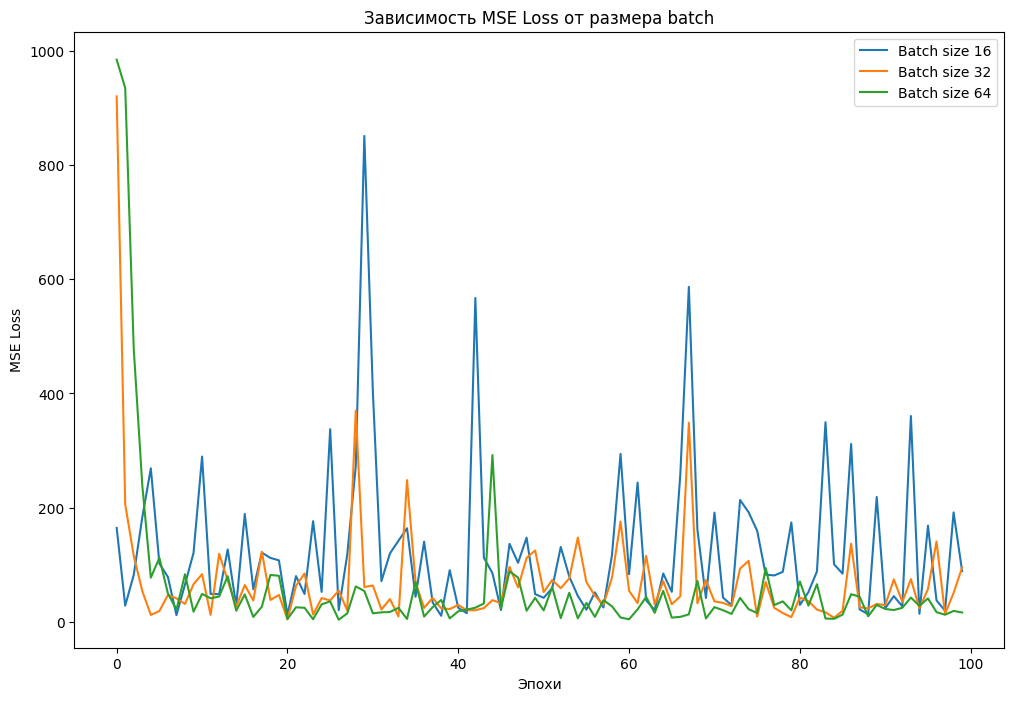

In [28]:
plt.figure(figsize=(12, 8))

for batch_size in batch_sizes:
    losses = np.mean(results[f'batch_size_{batch_size}'], axis=0)
    plt.plot(losses, label=f'Batch size {batch_size}')

plt.xlabel("Эпохи")
plt.ylabel("MSE Loss")
plt.title("Зависимость MSE Loss от размера batch")
plt.legend()
plt.show()

In [35]:
best_batch_size = 64
configs = {
    "no_bn_no_dropout": (False, 0.0),
    "bn_no_dropout": (True, 0.0),
    "no_bn_dropout": (False, 0.2),
    "bn_dropout": (True, 0.2)
}

In [36]:
test_results = {}

for name, (bn, dropout) in configs.items():
    losses_per_func = []
    for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
        model = RegressionModel(batch_norm=bn, dropout=dropout)
        losses = train_model(model, X_train, y_train, X_test, y_test, best_batch_size)
        losses_per_func.append(losses)
    test_results[name] = losses_per_func

**График ошибки разных конфигураций для каждого датасета**

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


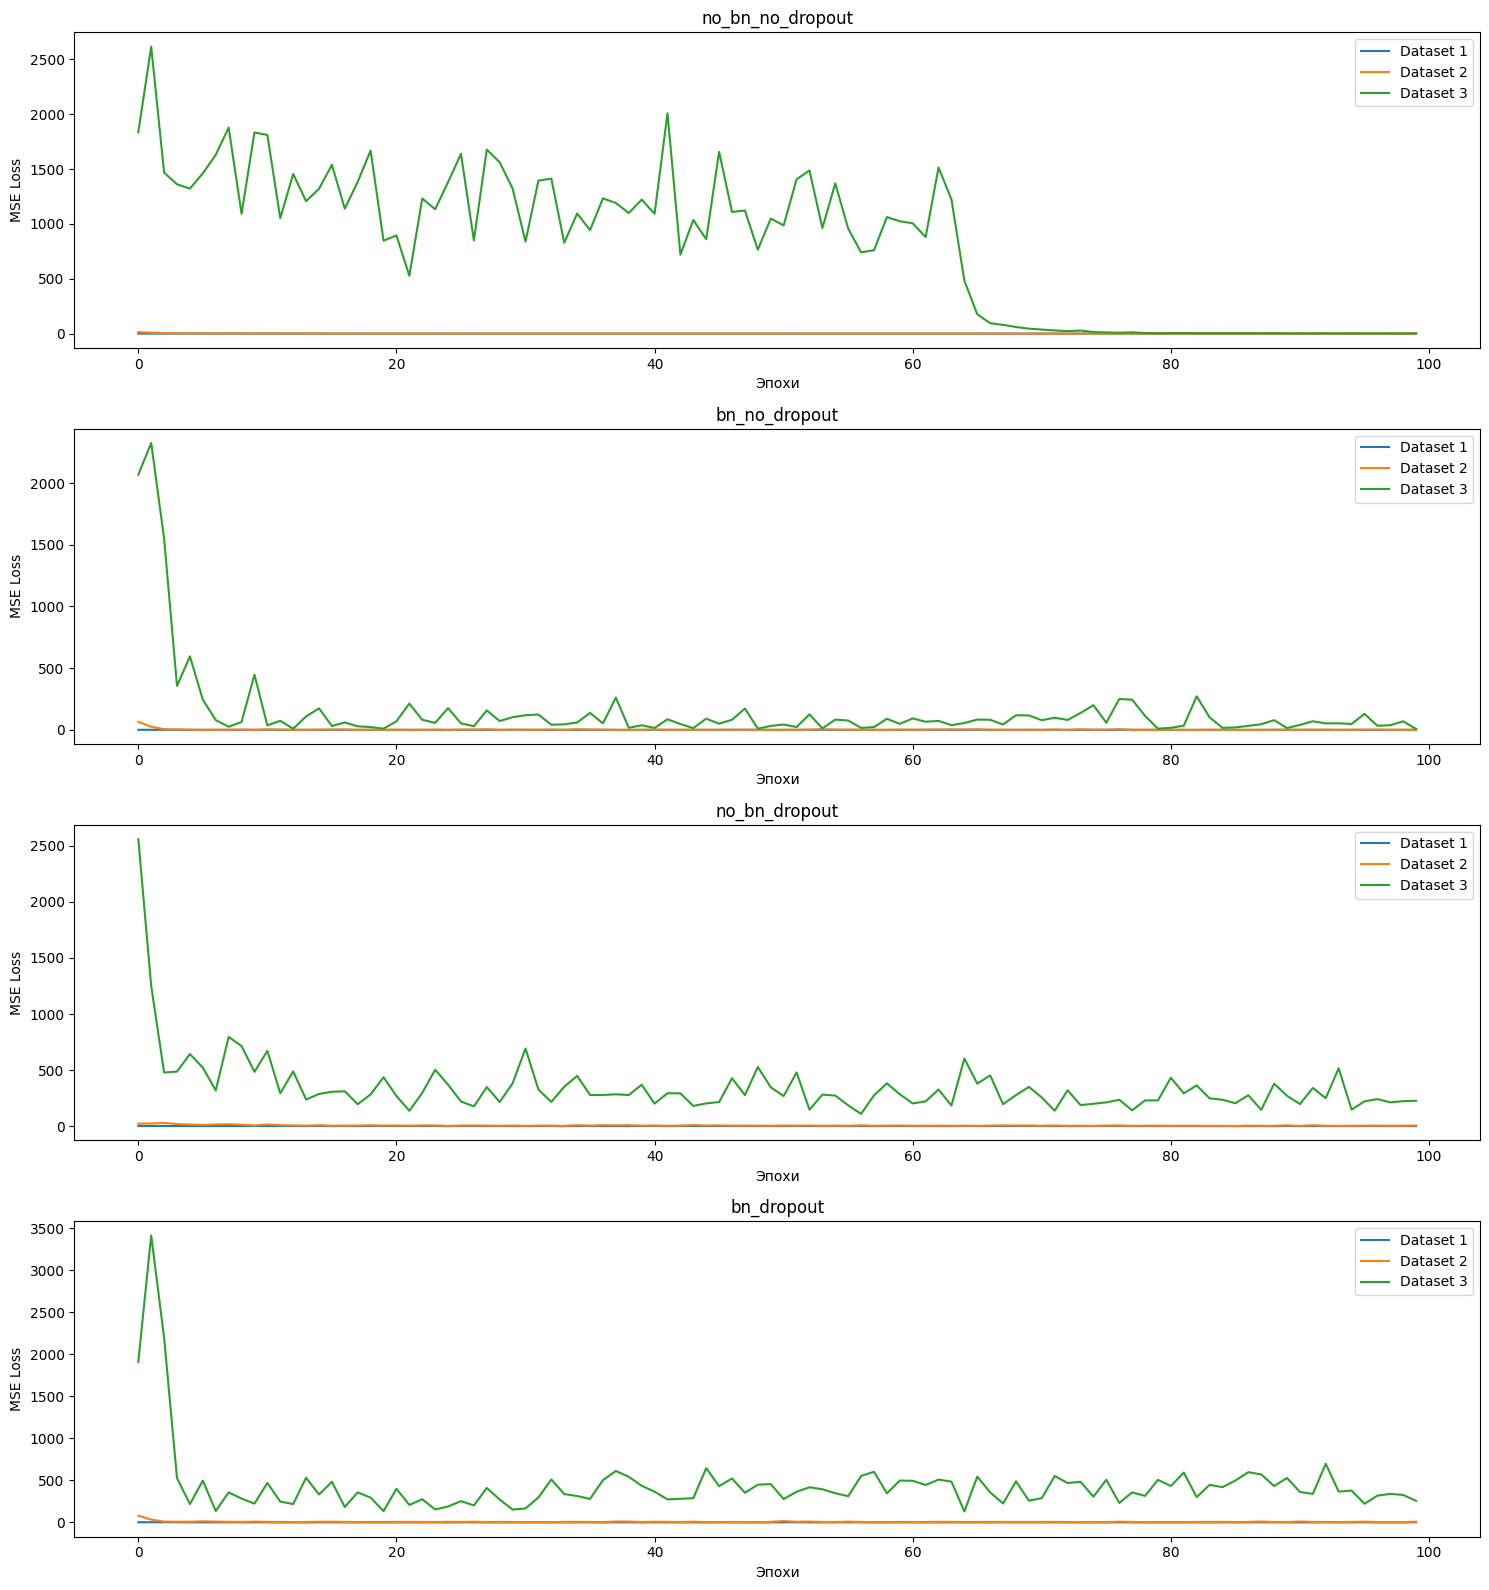

In [40]:
plt.figure(figsize=(15, 4 * num_configs))

num_configs = len(test_results)
for i, (name, losses) in enumerate(test_results.items()):
    plt.subplot(num_configs, 1, i + 1)
    for j, loss in enumerate(losses):
        plt.plot(loss, label=f"Dataset {j+1}")

    plt.xlabel("Эпохи")
    plt.ylabel("MSE Loss")
    plt.title(name)
    plt.legend()

plt.tight_layout()
plt.show()


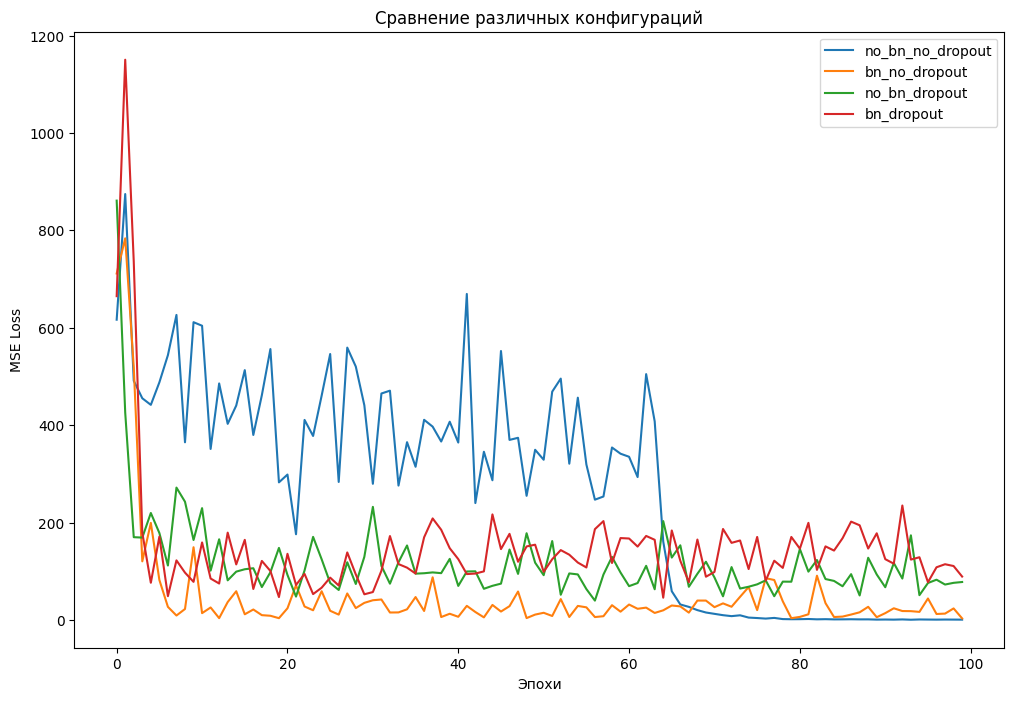

In [38]:
plt.figure(figsize=(12, 8))
for name, losses in test_results.items():
    plt.plot(np.mean(losses, axis=0), label=name)
plt.xlabel("Эпохи")
plt.ylabel("MSE Loss")
plt.title("Сравнение различных конфигураций")
plt.legend()
plt.show()

После рассмотрения разных конфигураций работы модели можно сказать, что и дропаут ,и банчнорм улучшают качество модели. Для более сложной функции, модель без банчнорма и дропаута после 60 эпохи начала переобучатся. Также можно сказать что дропаут и банчнорм помогают при переобучении модели